In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:05<00:00, 29324628.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(valset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

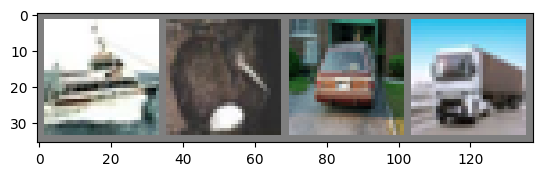

tensor(8) tensor(2) tensor(1) tensor(9)


In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j] for j in range(4)))
#classes = 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class Mymodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


In [11]:
class SequentiaMymodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_model = nn.Sequential(
            nn.Linear(3072, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.linear_model(x)
        return x


In [12]:
model = Mymodel()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Mymodel(
  (fc1): Linear(in_features=3072, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=10, bias=True)
)

In [13]:
import torch.optim as optim

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters())

In [15]:
EPOCH = 5

In [17]:
train_loss_history = []
val_loss_history = []
for epoch in range(EPOCH):
    train_loss = 0
    val_loss = 0
    total = 0
    correct = 0
    for i, data in enumerate(train_loader):
        x, y = data
        x = x.reshape(-1, 32*32*3) # flatten
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad() #gradient 초기화

        y_pred = model(x)

        loss = criterion(y_pred, y)

        loss.backward() #backpropagation
        optimizer.step() #update
        
        train_loss += loss.item()
    train_loss/=len(train_loader)
    train_loss_history.append(train_loss)

    with torch.no_grad(): # val set 학습을 꺼둠
        for i, data in enumerate(val_loader):
            x, y = data
            x = x.reshape(-1, 32*32*3) # flatten
            x = x.to(device)
            y = y.to(device)

            output = model(x)
            loss = criterion(output, y)

            val_loss += loss.item()


            _, pred = torch.max(output.data, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)
    val_acc = 100 * correct / total
    
    print(f"epoch {epoch} train loss {train_loss:.3f} val loss {val_loss:.3f}")
    print(f"val acc {val_acc:.3f}")
    

epoch 0 train loss 1.628 val loss 1.626
val acc 43.390
epoch 1 train loss 1.561 val loss 1.573
val acc 45.860
epoch 2 train loss 1.520 val loss 1.524
val acc 46.970
epoch 3 train loss 1.462 val loss 1.505
val acc 46.550
epoch 4 train loss 1.413 val loss 1.538
val acc 46.750


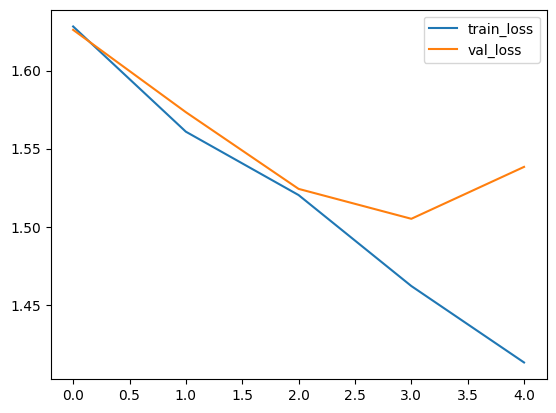

In [18]:
plt.plot(np.arange(epoch+1), train_loss_history, label='train_loss')
plt.plot(np.arange(epoch+1), val_loss_history, label='val_loss')
plt.legend()
plt.show()